# Import Required Libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from imblearn.over_sampling import SMOTE 

import joblib
import warnings
warnings.filterwarnings("ignore")


# Load Dataset

In [6]:
df = pd.read_csv("dataset.csv")
print(df.shape)
df.head()


(30100, 44)


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,is_claim,segment,model,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,0,A,M1,...,No,No,No,No,Yes,No,No,No,Yes,0
1,ID00002,0.672619,0.02,0.375000,C2,"27003""",1,0,A,M1,...,No,No,No,No,Yes,No,No,No,Yes,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,0,A,M1,...,No,No,No,No,Yes,No,No,No,Yes,0
3,ID00004,0.900277,0.11,0.432692,C4,"21622""",1,0,C1,M2,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,0,A,M3,...,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2


# Data Cleaning

In [7]:
# 3.1 Remove duplicates
df.drop_duplicates(inplace=True)


In [8]:
# 3.2 Drop irrelevant column
df.drop("policy_id", axis=1, inplace=True)


# Missing Value Visualization

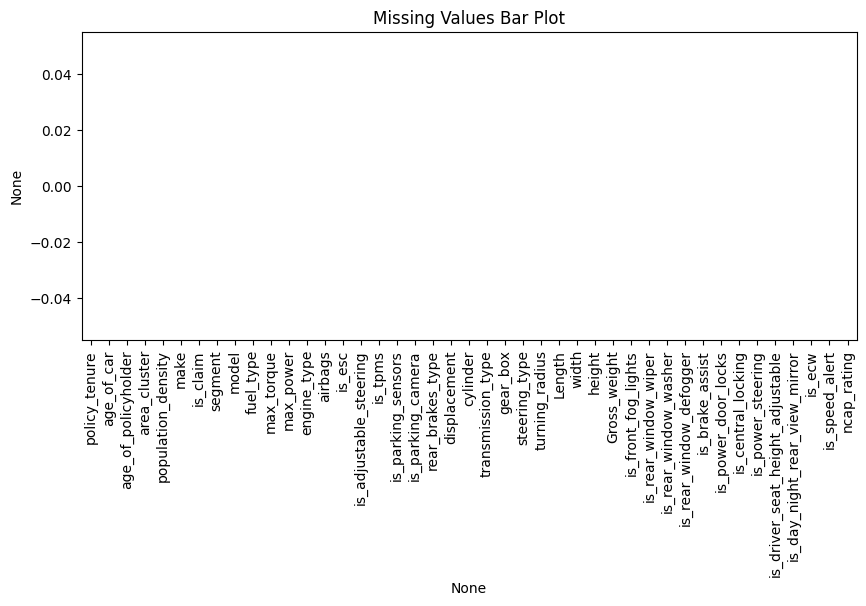

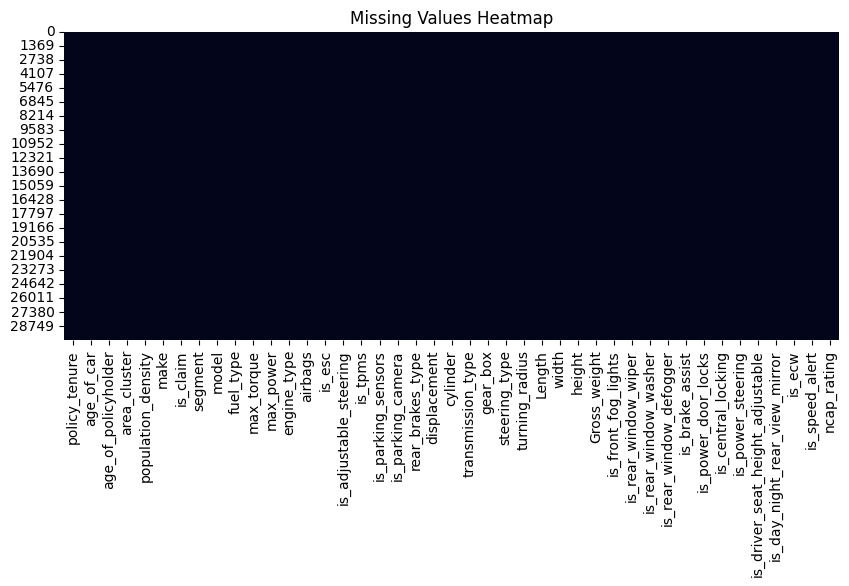

In [9]:
plt.figure(figsize=(10,4))
sns.barplot(x=df.columns, y=df.isnull().sum())
plt.xticks(rotation=90)
plt.title("Missing Values Bar Plot")
plt.show()

plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Handle missing values

In [10]:
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)


# Feature Engineering (Extracting Values From The Existing Features)

In [11]:
# 5.1 Extract torque & rpm
df["rpm_T"] = df["max_torque"].str.extract(r'@(\d+)').astype(float)
df["torque"] = df["max_torque"].str.extract(r'(\d+)').astype(float)

df["rpm_P"] = df["max_power"].str.extract(r'@(\d+)').astype(float)
df["power"] = df["max_power"].str.extract(r'(\d+)').astype(float)


In [12]:
# 5.2 Create required columns
df["torque_rpm_ratio"] = df["torque"] / df["rpm_T"]
df["power_rpm_ratio"] = df["power"] / df["rpm_P"]


# Convert population_density to numeric

In [13]:
df["population_density"] = (
    df["population_density"]
    .astype(str)
    .str.replace(r"[^0-9.]", "", regex=True)
    .astype(float)
)


# Label Encoding

In [14]:
le = LabelEncoder()

categorical_cols = df.select_dtypes(include="object").columns

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


# Apply One-Hot Encoding on Some Categorical Columns To Extend The No. Of Columns

In [15]:
categorical_cols = [
    "segment",
    "area_cluster",
    "model",
    "fuel_type",
    "engine_type",
    "rear_brakes_type",
    "transmission_type",
    "steering_type"
]

df = pd.get_dummies(
    df,
    columns=categorical_cols,
    drop_first=True
)



# Independant Column And Dependant Columns

In [16]:
X = df.drop("is_claim", axis=1)
y = df["is_claim"]

print("Total Features:", X.shape[1]) 


Total Features: 92


# Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)


# Feature Scaling

In [18]:
scaler = StandardScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)


# Handle Imbalanced Data (SMOTE)

In [19]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


# Model Building

In [20]:
models = {
    "Logistic Regression": LogisticRegressionCV(),
    "KNN (k=100)": KNeighborsClassifier(n_neighbors=100),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}


# Model Evaluation

In [21]:
results = []

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)



Logistic Regression
Accuracy: 0.5840531561461794
Precision: 0.0890894819466248
Recall: 0.5536585365853659
F1 Score: 0.1534820824881677

KNN (k=100)
Accuracy: 0.5230897009966777
Precision: 0.08245673566338649
Recall: 0.5926829268292683
F1 Score: 0.1447721179624665

SVM
Accuracy: 0.5255813953488372
Precision: 0.08849259757738896
Recall: 0.6414634146341464
F1 Score: 0.15552927261975164

Decision Tree
Accuracy: 0.8578073089700997
Precision: 0.0900735294117647
Recall: 0.11951219512195121
F1 Score: 0.10272536687631027


# Performance Summary

In [22]:
summary_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]
)

summary_df


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.584053,0.089089,0.553659,0.153482
1,KNN (k=100),0.523090,0.082457,0.592683,0.144772
2,SVM,0.525581,0.088493,0.641463,0.155529
3,Decision Tree,0.857807,0.090074,0.119512,0.102725


 # Best Model Selection

In [23]:
best_model = models["Decision Tree"]


In [24]:
joblib.dump(
    {
        "model": best_model,
        "scaler": scaler,
        "feature_columns": X.columns.tolist()
    },
    "insurance_bundle.pkl"
)

print("Model saved successfully!")


Model saved successfully!
